# Unexpected subgraphs
---

Given an attributed graph $\mathcal{G}=(\mathcal{V, E, A})$, use **unexpectedness** $U=C_w - C$ to filter out attributed subgraphs $G_i=(V_i, E_i, A_i)$.

The unexpectedness of an attributed subgraph $G = (V, E, A)$ is defined as the sum of the unexpectedness of its structure $g$ and the unexpectedness of the set of attributes its nodes are sharing $A$
$$
U(G) = U(g) + U(A)
$$

**Subgraph structure** $g$   
* $U(g)=C_w(g) - C(g)$
* description complexity $C(g)$ is the number of bits to describe vertices and edges in graph  
$C(g) = \log(|V|) + \sum_{v \in V}\log{(b+1)} + \log(\binom{|V|}{k_v})$, with $b=\max_{v \in V}(\text{deg}(v))$ and $k$ is the number of non zero elements in a row  
* generation complexity $C_w(g)$ is the number of bits to describe a random graph sampled in original graph $\mathcal{G}$, with a given number of nodes and density

**Attributes** $A$
* $U(A)=C_w(A)-C(A)$
* description complexity $C(A)$ is the minimum description length for identifying the subgraph sharing characteristics $A \in \mathcal{A}$. It is defined using the number of occurences of each attribute $a \in A$, $\#a$. With this approach, a very common attribute such as '$\texttt{the}$' will yield a large complexity, whereas a non-common attribute will be considered as less complex.  
$C(A)=\sum_{a \in A}\log(\#a)$ 
* generation complexity $C_w(A)$ is the minimum description length to describe a set of $|A|$ elements from a vocabulary of size $\mathcal{A}$  
$C_w(A)=\log(\binom{|\mathcal{A}|}{|A|})$

In [2]:
from collections import defaultdict, Counter
from contextlib import redirect_stdout
from IPython.display import SVG
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import random
import seaborn as sns
from scipy import sparse, special

from sknetwork.clustering import get_modularity, KMeans, Louvain
from sknetwork.data import load_netset, from_edge_list
from sknetwork.embedding import Spectral, SVD
from sknetwork.gnn import GNNClassifier
from sknetwork.ranking import top_k
from sknetwork.topology import Triangles, Cliques, get_connected_components
from sknetwork.utils import get_degrees, get_membership, get_neighbors
from sknetwork.utils.kmeans import KMeansDense
from sknetwork.utils.check import get_probs
from sknetwork.visualization import svg_graph

from tfidf import TfIdf

In [3]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [4]:
adjacency = wikivitals.adjacency
biadjacency = wikivitals.biadjacency
names = wikivitals.names
words = wikivitals.names_col
labels = wikivitals.labels

In [40]:
def plot_distrib(values, ax, xlabel='degree', log=True, title=None, color='blue', alpha=1, label='Degree distribution'):
    counter = Counter(values)
    x, y = zip(*counter.items())
    ax.scatter(x, y, marker='+', color=color, alpha=alpha, label=label)
    ax.legend()
    ax.set_title(title)
    if log:
        ax.set_xscale('log')
        ax.set_xlabel(xlabel + ' (log)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency' + ' (log)')
    ax.set_yscale('log')
    
def mdl_graph(adjacency):
    n = adjacency.shape[0]

    # density
    #d = np.sum(adjacency) / (n * (n - 1))
    
    # nodes
    nodes_mdl = np.log2(n)
    
    # edges
    degrees = adjacency.dot(np.ones(n))
    max_degree = np.max(degrees)
    edges_mdl = (n + 1) * np.log2(max_degree + 1) + np.sum([np.log2(special.comb(n, deg)) for deg in degrees])

    if n == 1:
        return 1
    else:
        return (nodes_mdl + edges_mdl)

def entropy(prob):
    return prob * -np.log2(prob)

def desc_complexity(attrs):
    if isinstance(attrs, int):
        attrs = [attrs]
    prob = 1
    for attr in attrs:
        prob *= degrees[attr] / np.sum(degrees)
    entr = entropy(prob)
    return generation_complexity(biadjacency.shape[1], len(attrs)) * entr

def expand_list(l, idx, item):
    """If l[idx] does not exists, expand l with item."""
    try:
        l[idx] = item
    except IndexError:
        extents.append(item)    

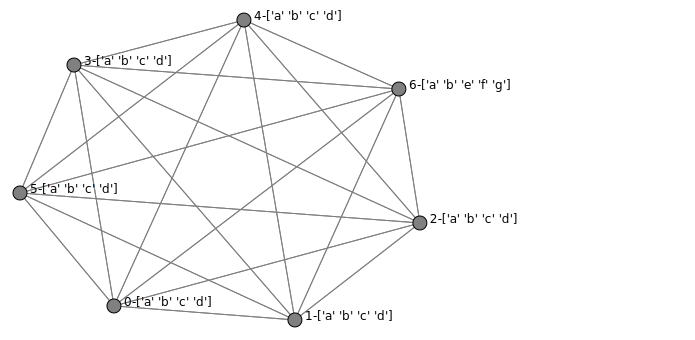

In [153]:
SVG(svg_graph(G8, names=[n + '-' + str(names_col8[x.indices]) for n, x in zip(names8, X8)]))

In [179]:
def graph_enum(g, p, s, EL, graph_obj):
    q = # pattern language
    return 0

g_pattern_list = []
G = G8.copy()
p = (set(), np.arange(G.shape[0]))
#p_lang = p.intent()
graph_enum(G, p, s=2, EL=set(), graph_obj=G)

0

In [182]:
extent = extension(np.array([]), X8)
print(extent)
intent = intention(extent, X8)
intent

[0 1 2 3 4 5 6]


array([0, 1], dtype=int32)

In [199]:
def is_cannonical(context, extents, intents, r, y):
    global r_new

    for k in range(len(intents[r])-1, -1, -1):
        for j in range(y, intents[r][k], -1):            
            for h in range(len(extents[r_new])):
                if context[extents[r_new][h], j] == 0:
                    h -= 1 # Necessary for next test in case last interaction of h for-loop returns False
                    break
            if h == len(extents[r_new]) - 1:
                return False
        y = intents[r][k] - 1

    for j in reversed(range(y, -1, -1)):
        for h in range(len(extents[r_new])):
            if context[extents[r_new][h], j] == 0:
                h -= 1 # Necessary for next test in case last interaction of h for-loop returns False
                break
        if h == len(extents[r_new]) - 1:
            return False
    
    return True

def extension(attrs, context):
    ext = set()
    if len(attrs) == 0:
        return np.arange(0, context.shape[0])
    for a in attrs:
        nodes = set(get_neighbors(context, node=a, transpose=True))
        if len(ext) == 0:
            ext.update(nodes)
        else:
            ext &= nodes
        if len(ext) == 0:
            break
    return np.asarray(list(ext))

def intention(nodes, context):
    intent = set()
    if len(nodes) == 0:
        return np.arange(0, context.shape[1])
    for n in nodes:
        attrs = set(get_neighbors(context, node=n))
        if len(intent) == 0:
            intent.update(attrs)
        else:
            intent &= attrs
        if len(attrs) == 0:
            break
    return np.asarray(list(intent))

In [330]:
def init_inclose(context):
    extents, intents = [], []
    extents_init = np.arange(context.shape[0])
    intents_init = []
    extents.append(extents_init) # Initalize extents with all objects from context
    intents.append(intents_init) # Initialize intents with empty set attributes
    return extents, intents

def in_close_new(adjacency, context, extents, intents, r=0, y=0, min_support=0, max_support=np.inf, degs=[], unexs_g=[], unexs_a=[], unexs=[]):
    global r_new
    r_new = r_new + 1
    
    for j in np.arange(context.shape[1])[y:]:
        try:
            extents[r_new] = []
            unexs_g[r_new] = 0
            unexs_a[r_new] = 0
            unexs[r_new] = 0
        except IndexError:
            extents.append([])
            unexs_g.append(0)
            unexs_a.append(0)
            unexs.append(0)
            
        # ------------------------------------------------
        # Graph unexpectedness 
        g_r = adjacency[extents[r_new-1]][:, extents[r_new-1]]
        complexity_desc_g = mdl_graph(g_r)
        complexity_gen_g = np.mean(complexity_gen_graphs.get(len(extents[r_new-1])))
        unex_g = complexity_gen_g - complexity_desc_g
        #unexs_g.append(unex_g)
        unexs_g[r_new] = unex_g
        print(f'  U(G): {unex_g}')

        # Attributes unexpectedness
        complexity_gen_a = np.log2(special.comb(context.shape[1], len(intents[r_new-1])))
        complexity_desc_a = 0
        for a in intents[r_new-1]:
            complexity_desc_a += np.log2(degs[a])
        unex_a = complexity_gen_a - complexity_desc_a
        unexs_a[r_new] = unex_a
        print(f'  U(A): {unex_a}')

        # Total unexpectedness
        unex = unex_g + unex_a
        unexs[r_new] = unex
        print(f'  U: {unex}')
        # ------------------------------------------------
            
        # Form a new extent by adding extension of attribute j to current concept extent
        ext_j = set(extension([j], context))
        extents[r_new] = list(sorted(set(extents[r]).intersection(ext_j)))
        len_new_extent = len(extents[r_new])
        
        print(f'extents: {extents[r]} - intents: {intents[r]}')
        print(f'  Candidate attr: {j}')
        print(f'  new extent: {extents[r_new]}')
        
        if (len_new_extent > min_support) and (len_new_extent < max_support):
                       
            if len_new_extent == len(extents[r]):
                print(f'  Extent size did not change -> attribute {j} is added to intent.')
                intents[r] = list(sorted(set(intents[r]).union(set([j]))))
            else:
                print(f'  Extent size DID change. IsCannonical: {is_cannonical(context, extents, intents, r, j - 1)}')
                if is_cannonical(context, extents, intents, r, j - 1):
                    print(f'   New branch will be created, compute U of current concept.')
                    
                    try:
                        intents[r_new] = []
                        #unexs_g[r_new] = 0
                        #unexs_a[r_new] = 0
                        #unexs[r_new] = 0
                    except IndexError:
                        intents.append([])
                        #unexs_g.append(0)
                        #unexs_a.append(0)
                        #unexs.append(0)
                    
                    intents[r_new] = list(sorted(set(intents[r]).union(set([j]))))
                    len_new_intent = len(intents[r_new])
                    print(f'  Intent: {intents[r_new]}')
                    print(f'  --> Enter recursion...')
                    
                    print(f'      **Unexpectedness: {unexs}')
                    in_close_new(adjacency, context, extents, intents, r=r_new, y=j+1, degs=degs, unexs_g=unexs_g, unexs_a=unexs_a, unexs=unexs)

    print(unexs_g, unexs_a)
    print(f'**concept: ({[*zip(extents, intents)]})')
    
    return [*zip(extents, intents)]

In [331]:
extents, intents = init_inclose(X8)
degs = get_degrees(X8, transpose=True)
global r_new
r_new = 0
concepts = in_close_new(G8, X8, extents, intents, r=0, y=0, degs=degs, unexs_g=[0], unexs_a=[0], unexs=[0])
for c in concepts:
    print(c[0], names_col8[c[1]])

  U(G): 10.089684590105549
  U(A): 0.0
  U: 10.089684590105549
extents: [0 1 2 3 4 5 6] - intents: []
  Candidate attr: 0
  new extent: [0, 1, 2, 3, 4, 5, 6]
  Extent size did not change -> attribute 0 is added to intent.
  U(G): 10.089684590105549
  U(A): 0.0
  U: 10.089684590105549
extents: [0 1 2 3 4 5 6] - intents: [0]
  Candidate attr: 1
  new extent: [0, 1, 2, 3, 4, 5, 6]
  Extent size did not change -> attribute 1 is added to intent.
  U(G): 10.089684590105549
  U(A): -1.2223924213364477
  U: 8.8672921687691
extents: [0 1 2 3 4 5 6] - intents: [0, 1]
  Candidate attr: 2
  new extent: [0, 1, 2, 3, 4, 5]
  Extent size DID change. IsCannonical: True
   New branch will be created, compute U of current concept.
  Intent: [0, 1, 2]
  --> Enter recursion...
      **Unexpectedness: [0, 8.8672921687691]
  U(G): 7.001220597119904
  U(A): -3.070389327891399
  U: 3.930831269228505
extents: [0, 1, 2, 3, 4, 5] - intents: [0, 1, 2]
  Candidate attr: 3
  new extent: [0, 1, 2, 3, 4, 5]
  Extent 

In [105]:
def comeg(adjacency, context, extents, intents, unexs, unexs_g, r, y, degs, gain, support_obj, names_col, verbose):
    
    #support_obj = support_obj

    support_attr = 15
    support_common_remaining_attr = 1
    delta = 0
    
    global gain_unex
    # --------------------
    
    global r_new
    r_new = r_new + 1
    attributes = np.arange(0, context.shape[1])
    
    for n_iter, j in enumerate(attributes[y:]):
        
        try:
            extents[r_new] = []
            unexs[r_new] = 0
            unexs_g[r_new] = 0
        except IndexError:
            extents.append([])
            unexs.append(0)
            unexs_g.append(0)

        # Form a new extent by adding extension of attribute j to current concept extent
        extension_j = extension([j], context)
        new_extent = np.array(list(set(extents[r]).intersection(set(extension_j))))
        extents[r_new] = new_extent
        new_extent_size = len(new_extent)

        if new_extent_size >= support_obj:
            if verbose:
                print(f'n_iter:{n_iter} - extents: {extents[r]} - intents: {intents[r]}')
                print(f'  Candidate attr: {j} {names_col[j]}')
                print(f'  new extent: {new_extent}')

            #if new_extent_size < len(extents[r]):
            # Graph unexpectedness
            g_r_new = adjacency[new_extent][:, new_extent]
            complexity_desc_g = mdl_graph(g_r_new)
            complexity_gen_g = np.mean(complexity_gen_graphs.get(new_extent_size))
            unex_g = complexity_gen_g - complexity_desc_g
            unexs_g.append(unex_g)
            if verbose:
                print(f'  U(G)={unex_g} (cw={complexity_gen_g} - c={complexity_desc_g})')

            new_intent = intention(new_extent, context)
            #new_intent = np.array(list(sorted(set(intents[r]).union(set([j])))))
            new_intent_size = len(new_intent)            

            if new_intent_size <= support_attr:

                # Attributes unexpectedness
                complexity_gen_a = np.log2(special.comb(context.shape[1], new_intent_size))
                complexity_desc_a = 0
                for a in new_intent:
                    complexity_desc_a += np.log2(degs[a])
                unex_a = complexity_gen_a - complexity_desc_a
                if verbose:
                    print(f'  U(A)={unex_a} (cw={complexity_gen_a} - c={complexity_desc_a})')

                # Total Unexpectedness
                unex = unex_g + unex_a
                if verbose:
                    print(f'  U: {unex}')
                unexs[r_new] = unex

                if verbose:
                    print(f'  U[r_new]={unex} - U[r]={unexs[r]}  = {unex - unexs[r]}')

                gain_unex.append(unex - unexs[r])
                if verbose:
                    print(f'  gain unex: {gain_unex}')
                    print(f'  Gain unex diff: {np.abs(gain_unex[-2] - gain_unex[-1])}')

                if new_extent_size == len(extents[r]):

                    #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                    if (len(intents[r]) == 0) or ((unex - unexs[r] > 0) and (np.abs(gain_unex[-2] - gain_unex[-1])) > delta):
                        #intents[r] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                        intents[r] = np.array(new_intent)
                        extents[r] = extents[r_new]
                        unexs_g[r] = unex_g
                        unexs[r] = unex
                        if verbose:
                            print(f'  Attribute {j}-{names_col[j]} added')
                    else:
                        if verbose:
                            print(f'  unex - unexs[r] > 0 : {(unex - unexs[r] > 0)}')
                            print(f'  (gain_unex[-2] - gain_unex[-1]) > delta : {(gain_unex[-2] - gain_unex[-1]) > delta}')
                            print(f'  len(intents[r]) == 0 : {len(intents[r]) == 0}')
                            print(f'  --> Stop branch recursion. ')
                            print('\n')

                        #del gain_unex[(r_new-r):]
                            if len(intents[r]) > 1:
                                del gain_unex[-(len(intents[r]))+1:]
                            else:
                                del gain_unex[-(len(intents[r])):]

                        return [*zip(extents, intents)]

                else:
                    #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                    if (len(intents[r]) == 0) or (unex - unexs[r] > 0):

                        try:
                            intents[r_new] = []
                        except IndexError:
                            intents.append([])

                        intents[r_new] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                        if verbose:
                            print('  recursive call')
                        
                        intersection = set(intents[r_new]).intersection(set(intents[r_new-1]))
                        print(intersection)
                        if len(intersection) == 0:
                            in_close(adjacency, context, extents, intents, unexs, unexs_g, r=r_new, y=j+1, degs=degs, gain=gain_unex, 
                                     support_obj=support_obj, names_col=names_col, verbose=verbose)
                    else:
                        if verbose:
                            print(f'  Do not go into recursion. Try next candidate attribute. ')
                            print()
                        gain_unex.pop(-1)
            else:
                if verbose:
                    print(f'Max number of attributes reached.')
                    print('\n')
                return [*zip(extents, intents)]

            #else:
            #    if verbose:
            #        print(f'  New extent size >= support? : {new_extent_size >= support_obj}')
            
        #else:
            #if verbose:
                #    print(f'closure of {new_extent} --> no need to verify all attributes')
    if verbose:
        print('\n')
        

    if len(intents[r]) > 1:
        del gain_unex[-(len(intents[r]))+1:]
    else:
        del gain_unex[-(len(intents[r])):]
    return [*zip(extents, intents)]

In [106]:
result, sorted_names_col = run_algorithm_comeg(G8, X8, names_col8, 1, 1000, 'log_custom11')
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5 6] ['a' 'b']
[6] ['e' 'f' 'g']
[0 1 2 3 4 5] ['c' 'd']
[0 1 2 3 4 5 6] ['d']


In [183]:
def in_close(adjacency, context, extents, intents, unexs, unexs_g, r, y, degs, gain, support_obj, names_col, verbose):
    
    #support_obj = support_obj

    support_attr = 15
    support_common_remaining_attr = 1
    delta = 0
    
    global gain_unex
    # --------------------
    
    global r_new
    r_new = r_new + 1
    attributes = np.arange(0, context.shape[1])
    
    for n_iter, j in enumerate(attributes[y:]):
        
        try:
            extents[r_new] = []
            unexs[r_new] = 0
            unexs_g[r_new] = 0
        except IndexError:
            extents.append([])
            unexs.append(0)
            unexs_g.append(0)

        # Form a new extent by adding extension of attribute j to current concept extent
        extension_j = get_neighbors(context, node=j, transpose=True)
        new_extent = np.array(list(set(extents[r]).intersection(set(extension_j))))
        extents[r_new] = new_extent
        new_extent_size = len(new_extent)
        
        # Verify that intention: prune recursion if the current none of the current extent neighbor have common attribute anymore
        len_closure = 0
        if len(new_extent > 0):
            all_neighbs = set(get_neighbors(context, node=new_extent[0]))
            for o in new_extent[1:]:
                neighbs = get_neighbors(context, node=o)
                all_neighbs &= set(neighbs)
            len_closure = len(all_neighbs)
        
        if len_closure >= support_common_remaining_attr:
            #if verbose:
            #    print(f'closure of {new_extent} --> size of closure = {len_closure}>{support_obj}')
            
            
            if new_extent_size >= support_obj:
                if verbose:
                    print(f'n_iter:{n_iter} - extents: {extents[r]} - intents: {intents[r]}')
                    print(f'  Candidate attr: {j} {names_col[j]}')
                    print(f'  new extent: {new_extent}')

                #if new_extent_size < len(extents[r]):
                # Graph unexpectedness
                g_r_new = adjacency[new_extent][:, new_extent]
                complexity_desc_g = mdl_graph(g_r_new)
                complexity_gen_g = np.mean(complexity_gen_graphs.get(new_extent_size))
                unex_g = complexity_gen_g - complexity_desc_g
                unexs_g.append(unex_g)
                if verbose:
                    print(f'  U(G)={unex_g} (cw={complexity_gen_g} - c={complexity_desc_g})')

                new_intent = np.array(list(sorted(set(intents[r]).union(set([j])))))
                new_intent_size = len(new_intent)            

                if new_intent_size <= support_attr:

                    # Attributes unexpectedness
                    complexity_gen_a = np.log2(special.comb(context.shape[1], new_intent_size))
                    complexity_desc_a = 0
                    for a in new_intent:
                        complexity_desc_a += np.log2(degs[a])
                    unex_a = complexity_gen_a - complexity_desc_a
                    if verbose:
                        print(f'  U(A)={unex_a} (cw={complexity_gen_a} - c={complexity_desc_a})')

                    # Total Unexpectedness
                    unex = unex_g + unex_a
                    if verbose:
                        print(f'  U: {unex}')
                    unexs[r_new] = unex

                    if verbose:
                        print(f'  U[r_new]={unex} - U[r]={unexs[r]}  = {unex - unexs[r]}')

                    gain_unex.append(unex - unexs[r])
                    if verbose:
                        print(f'  gain unex: {gain_unex}')
                        print(f'  Gain unex diff: {np.abs(gain_unex[-2]-gain_unex[-1])}')

                    if new_extent_size == len(extents[r]):

                        #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                        #if (len(intents[r]) == 0) or ((unex - unexs[r] > 0) and (np.abs(gain_unex[-2] - gain_unex[-1])) > delta):
                        intents[r] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                        extents[r] = extents[r_new]
                        unexs_g[r] = unex_g
                        unexs[r] = unex
                        if verbose:
                            print(f'  Attribute {j}-{sorted_names_col[j]} added')
                        #else:
                        #    if verbose:
                        #        print(f'  unex - unexs[r] > 0 : {(unex - unexs[r] > 0)}')
                        #        print(f'  (gain_unex[-2] - gain_unex[-1]) > delta : {(gain_unex[-2] - gain_unex[-1]) > delta}')
                        #        print(f'  len(intents[r]) == 0 : {len(intents[r]) == 0}')
                        #        print(f'  --> Stop branch recursion. ')
                        #       print('\n')

                            #del gain_unex[(r_new-r):]
                        #        if len(intents[r]) > 1:
                        #            del gain_unex[-(len(intents[r]))+1:]
                        #        else:
                        #            del gain_unex[-(len(intents[r])):]

                        #    return [*zip(extents, intents)]

                    else:
                        #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                        if (len(intents[r]) == 0) or (unex - unexs[r] > 0):

                            try:
                                intents[r_new] = []
                            except IndexError:
                                intents.append([])

                            intents[r_new] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                            if verbose:
                                print('  recursive call')
                            in_close(adjacency, context, extents, intents, unexs, unexs_g, r=r_new, y=j+1, degs=degs, gain=gain_unex, 
                                     support_obj=support_obj, names_col=names_col, verbose=verbose)
                        else:
                            if verbose:
                                print(f'  Do not go into recursion. Try next candidate attribute. ')
                                print()
                            gain_unex.pop(-1)
                else:
                    if verbose:
                        print(f'Max number of attributes reached.')
                        print('\n')
                    return [*zip(extents, intents)]

            #else:
            #    if verbose:
            #        print(f'  New extent size >= support? : {new_extent_size >= support_obj}')
            
        #else:
            #if verbose:
                #    print(f'closure of {new_extent} --> no need to verify all attributes')
    if verbose:
        print('\n')
        

    if len(intents[r]) > 1:
        del gain_unex[-(len(intents[r]))+1:]
    else:
        del gain_unex[-(len(intents[r])):]
    return [*zip(extents, intents)]

In [184]:
def run_algorithm(G, X, names_col, n_objects_min, n_objects_max, out_name):
    # In-close initialization
    V = np.arange(0, X.shape[0])

    extents, intents, unexs, unexs_g = [], [], [], []
    extents_init = V
    intents_init = []
    unexs.append(0)
    unexs_g.append(0)
    extents.append(extents_init)
    intents.append(intents_init)
    
    global r_new
    r_new = 0
    global gain_unex
    gain_unex = []
    gain_unex.append(0)
    
    # Degree of attribute = # articles in which it appears
    freq_attribute = get_degrees(X.astype(bool), transpose=True)
    index = np.flatnonzero((freq_attribute <= n_objects_max) & (freq_attribute >= n_objects_min))
    
    # Filter data with index
    biadjacency = X[:, index]
    words = names_col[index]
    freq_attribute = freq_attribute[index]
    
    # Order attributes according to their ascending degree
    # This allows to add first attributes that will generate bigger subgraphs
    sort_index = np.argsort(freq_attribute)
    sorted_degs = freq_attribute[sort_index]
    filt_biadjacency = X[:, sort_index]
    sorted_names_col = words[sort_index]
    print(sorted_names_col)
    
    with open(f'logs/{out_name}.txt', 'w') as f:
        with redirect_stdout(f):
            result = in_close(G, filt_biadjacency, extents, intents, unexs, unexs_g, r=0, y=0, 
                              degs=sorted_degs, gain=gain_unex, support_obj=n_objects_min, names_col=sorted_names_col, verbose=True)
            print()
            
    return result, sorted_names_col

In [84]:
def run_algorithm_comeg(G, X, names_col, n_objects_min, n_objects_max, out_name):
    # In-close initialization
    V = np.arange(0, X.shape[0])

    extents, intents, unexs, unexs_g = [], [], [], []
    extents_init = V
    intents_init = []
    unexs.append(0)
    unexs_g.append(0)
    extents.append(extents_init)
    intents.append(intents_init)
    
    global r_new
    r_new = 0
    global gain_unex
    gain_unex = []
    gain_unex.append(0)
    
    # Degree of attribute = # articles in which it appears
    freq_attribute = get_degrees(X.astype(bool), transpose=True)
    index = np.flatnonzero((freq_attribute <= n_objects_max) & (freq_attribute >= n_objects_min))
    
    # Filter data with index
    biadjacency = X[:, index]
    words = names_col[index]
    freq_attribute = freq_attribute[index]
    
    # Order attributes according to their ascending degree
    # This allows to add first attributes that will generate bigger subgraphs
    sort_index = np.argsort(freq_attribute)
    sorted_degs = freq_attribute[sort_index]
    filt_biadjacency = X[:, sort_index]
    sorted_names_col = words[sort_index]
    
    with open(f'logs/{out_name}.txt', 'w') as f:
        with redirect_stdout(f):
            result = comeg(G, filt_biadjacency, extents, intents, unexs, unexs_g, r=0, y=0, 
                              degs=sorted_degs, gain=gain_unex, support_obj=n_objects_min, names_col=sorted_names_col, verbose=True)
            print()
    return result, sorted_names_col

## Custom graphs

In [8]:
%%time
complexity_gen_graphs = defaultdict(list)

for num_n in range(10 + 1)[1:15]:
    cpt = 0
    while cpt < 10:
        random_g = sparse.random(num_n, num_n, density=0.5).astype(bool).tocsr()
        if random_g is not None and random_g.shape[0] == num_n:
            mdl = mdl_graph(random_g)
            if num_n != 1:
                complexity_gen_graphs[num_n].append(mdl)
            else:
                # MDL of a graph of 1 node, is the MDL to describe this node
                complexity_gen_graphs[num_n].append(1)
            cpt += 1

CPU times: user 13.7 ms, sys: 2.04 ms, total: 15.7 ms
Wall time: 14.3 ms


### Custom1

In [13]:
G1 = sparse.csr_matrix(np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
]))
X1 = sparse.csr_matrix(np.array([
    [1, 0],
    [1, 0],
    [1, 0],
    [0, 1],
    [0, 1],
    [0, 1],
]))
names1 = np.array(['0', '1', '2', '3', '4', '5'])
names_col1 = np.array(['a', 'b'])

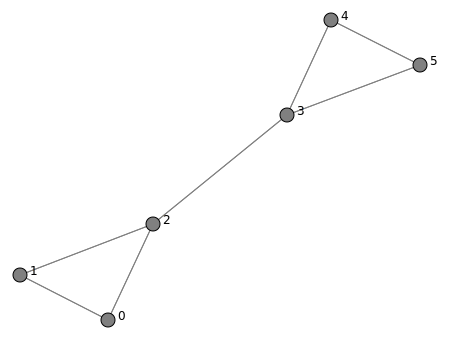

In [14]:
SVG(svg_graph(G1, names=names1))

In [15]:
%%time
result, sorted_names_col = run_algorithm(G1, X1, names_col1, 1, 1000, 'log_custom1')

['a' 'b']
CPU times: user 1.82 ms, sys: 1.37 ms, total: 3.19 ms
Wall time: 3.07 ms


In [16]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5] []
[0 1 2] ['a']
[3 4 5] ['b']


### Custom2

In [17]:
G2 = sparse.identity(6).tocsr()
X2 = sparse.identity(6).tocsr()
names2 = np.array(['0', '1', '2', '3', '4', '5'])
names_col2 = np.array(['a', 'b', 'c', 'd', 'e', 'f'])

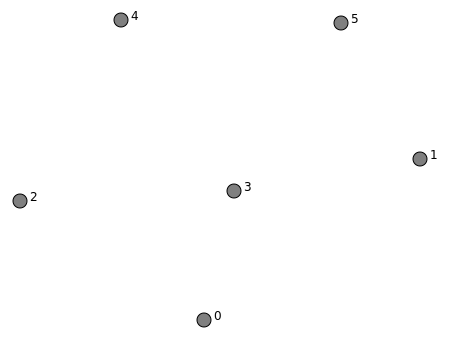

In [18]:
SVG(svg_graph(G2, names=names2))

In [19]:
%%time
result, sorted_names_col = run_algorithm(G2, X2, names_col2, 1, 1000, 'log_custom2')

['a' 'b' 'c' 'd' 'e' 'f']
CPU times: user 3.45 ms, sys: 1.23 ms, total: 4.68 ms
Wall time: 3.97 ms


In [20]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5] []
[0] ['a']
[1] ['b']
[2] ['c']
[3] ['d']
[4] ['e']
[5] ['f']


### Custom3

In [21]:
G3 = sparse.csr_matrix(np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
]))
X3 = sparse.csr_matrix(np.array([
    [1, 0, 1, 0, 0],
    [1, 0, 0, 1, 0],
    [1, 0, 0, 0, 1],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
]))
names3 = np.array(['0', '1', '2', '3', '4', '5'])
names_col3 = np.array(['a', 'b', 'c', 'd', 'e'])

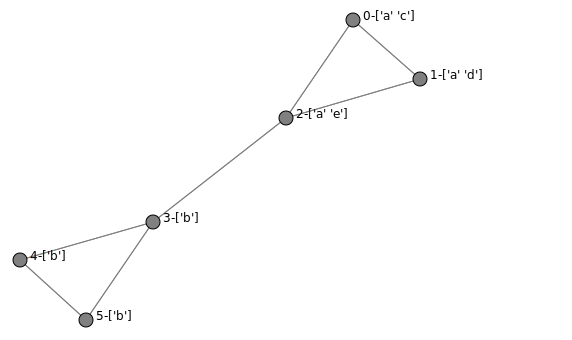

In [22]:
SVG(svg_graph(G3, names=[n + '-' + str(names_col3[x.indices]) for n, x in zip(names3, X3)]))

In [23]:
%%time
result, sorted_names_col = run_algorithm(G3, X3, names_col3, 1, 1000, 'log_custom3')

['c' 'd' 'e' 'a' 'b']
CPU times: user 3.69 ms, sys: 1.49 ms, total: 5.18 ms
Wall time: 4.73 ms


In [24]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5] []
[0] ['c']
[1] ['d']
[2] ['e']
[0 1 2] ['a']
[3 4 5] ['b']


Exemple d'itération de l'algo:
- `'c'` est l'attribut candidat $\rightarrow$ le sous-graphe $G_c$ = {0} est filtré $\rightarrow$ ce graphe est inattendu (comparé à l'ensemble vide) $\rightarrow$ on continue la récursion
- `'a'` est attribut candidat $\rightarrow$ le sous-graphe $G_{[c,a]}$ = {0} est filtré (inchangé) $\rightarrow$ ce graphe est moins inattendu que le précédent $\rightarrow$ l'attribut candidat n'est pas ajouté et on arrête la récursion **En effet, `'a'` est partagé par 3 noeuds et n'apporte pas de assez surprise par rapport à l'itération précédente**

### Custom4  

1 article which is the concatenation of 2 articles from different communities, citing other articles

In [25]:
G4 = sparse.csr_matrix(np.array([
    [0, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 0]
]))
X4 = sparse.csr_matrix(np.array([
    [1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 1],
]))
names4 = np.array(range(G4.shape[0])).astype(str)
names_col4 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])

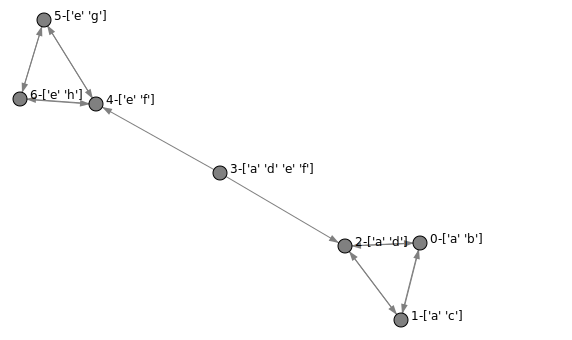

In [26]:
SVG(svg_graph(G4, names=[n + '-' + str(names_col4[x.indices]) for n, x in zip(names4, X4)]))

In [27]:
%%time
result, sorted_names_col = run_algorithm(G4, X4, names_col4, 1, 1000, 'log_custom4')

['b' 'c' 'g' 'h' 'd' 'f' 'a' 'e']
CPU times: user 5.85 ms, sys: 1.18 ms, total: 7.03 ms
Wall time: 8.17 ms


In [28]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5 6] []
[0] ['b']
[1] ['c']
[5] ['g']
[6] ['h']
[2 3] ['d']
[3 4] ['f']
[0 1 2 3] ['a']
[3 4 5 6] ['e']


* pros : 
     - les noeuds `5` et `6`, et `0` et `1` ne sont décrits que par leurs attributs discriminants
     - idem pour les concepts `[2, 3]` et `[3, 4]`
     - pas de concept avec un seul noeud si ce noeud est déjà dans d'autres concepts plus gr-ands
* cons: 
    - pas de concepts avec les noeuds `[2, 3, 4]` $\rightarrow$ on pourrait voir un concept inattendu qui regroupe ces noeuds ? mais comment prendre en compte la clôture vide ?
    - concept avec le noeud `3` et les attributs `['d', 'f']`, i.e discriminants ?

### Custom5  

1 article which is the concatenation of 2 articles from different communities, without citing other articles

In [29]:
G5 = sparse.csr_matrix(np.array([
    [0, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 0]
]))
X5 = sparse.csr_matrix(np.array([
    [1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 1],
]))
names5 = np.array(range(G5.shape[0])).astype(str)
names_col5 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])

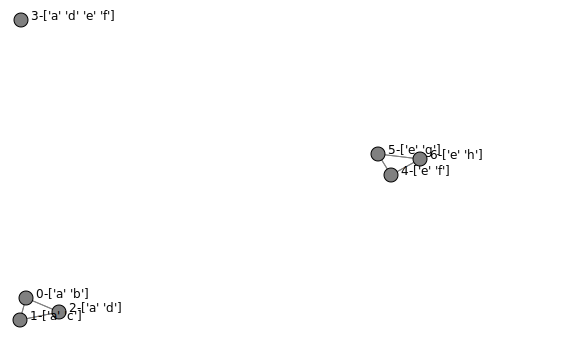

In [30]:
SVG(svg_graph(G5, names=[n + '-' + str(names_col5[x.indices]) for n, x in zip(names5, X5)]))

In [31]:
%%time
result, sorted_names_col = run_algorithm(G5, X5, names_col5, 1, 1000, 'log_custom5')

['b' 'c' 'g' 'h' 'd' 'f' 'a' 'e']
CPU times: user 5.98 ms, sys: 1.45 ms, total: 7.44 ms
Wall time: 6.3 ms


In [32]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5 6] []
[0] ['b']
[1] ['c']
[5] ['g']
[6] ['h']
[2 3] ['d']
[3 4] ['f']
[0 1 2 3] ['a']
[3 4 5 6] ['e']


* pros:
    - pas de concept avec un seul noeud si ce noeud est déjà dans d'autres concepts plus gr-ands
* cons: 
    - pas de concept avec les noeuds `[2, 3, 4]` (intersection vide) ?
    - pas de concept avec le noeud `3` uniquement ?

### Custom6  

Connected nodes without anything in common.

In [36]:
G6 = sparse.csr_matrix(np.array([
    [0, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0]
]))
X6 = sparse.csr_matrix(np.array([
    [1, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 1],
]))
names6 = np.array(range(G6.shape[0])).astype(str)
names_col6 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g'])

In [33]:
G6 = sparse.csr_matrix(np.array([
    [0, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0]
]))
X6 = sparse.csr_matrix(np.array([
    [1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1],
]))
names6 = np.array(range(G6.shape[0])).astype(str)
names_col6 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g'])

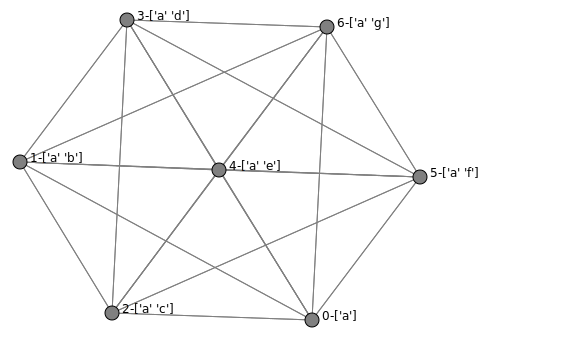

In [37]:
SVG(svg_graph(G6, names=[n + '-' + str(names_col6[x.indices]) for n, x in zip(names6, X6)]))

In [38]:
%%time
result, sorted_names_col = run_algorithm(G6, X6, names_col6, 1, 1000, 'log_custom6_bis')

['b' 'c' 'd' 'e' 'f' 'g' 'a']
CPU times: user 5.28 ms, sys: 1.75 ms, total: 7.03 ms
Wall time: 5.9 ms


In [39]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5 6] ['a']
[1] ['b']
[2] ['c']
[3] ['d']
[4] ['e']
[5] ['f']
[6] ['g']


* pros:
    - pas de concept avec tous les noeuds malgré la densité  
* cons:
    - perte d'information sur la structure du graphe initial ? 

### Custom7  

1 article between 1 strong community and one diverse community

In [147]:
G7 = sparse.csr_matrix(np.array([
    [0, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 0]
]))
X7 = sparse.csr_matrix(np.array([
    [1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 0],
    [0, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1]
]))
names7 = np.array(range(G7.shape[0])).astype(str)
names_col7 = np.array(['a', 'b', 'c', 'd', 'e', 'f'])

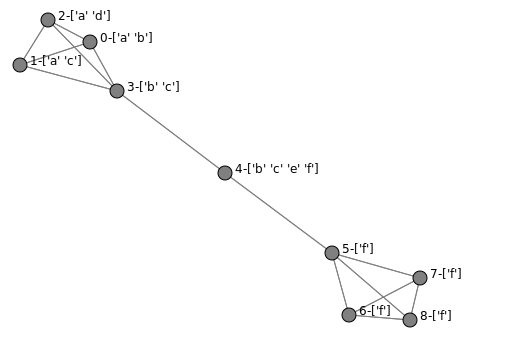

In [148]:
SVG(svg_graph(G7, names=[n + '-' + str(names_col7[x.indices]) for n, x in zip(names7, X7)]))

In [149]:
%%time
result, sorted_names_col = run_algorithm(G7, X7, names_col7, 1, 1000, 'log_custom7')

CPU times: user 14.3 ms, sys: 3.13 ms, total: 17.5 ms
Wall time: 15.3 ms


In [150]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5 6 7 8] []
[2] ['d']
[4] ['e']
[0 1 2] ['a']
[0] ['a' 'b']
[1] ['a' 'c']
[0 3 4] ['b']
[3 4] ['b' 'c']
[1 3 4] ['c']
[4 5 6 7 8] ['f']


* pros:
    - `4` n'est pas isolé de `[5, 6, 7, 8]`
    - `2` isolé (seul qui contient `'d'`)
    - `4` isolé (seul qui contient `'e'`)
* cons: 
    - `[3, 4]` n'est pas nécessaire si on a `[1, 3, 4]` et `[0, 3, 4]` ?
    - 

In [190]:
def get_summarized_graph(adjacency, concepts):
    """Get summarized graph given concepts and original adjacency matrix."""
    
    rows, cols = [], []

    for c in concepts:

        # exclude first element of lattice 
        if len(c[1]) > 0:
            nodes = sorted(c[0])
            idx = 0
            idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from concepts
            # reindex nodes
            for n in nodes:
                if n not in idx_nodes:
                    idx_nodes[idx] = n
                    idx += 1
            
            # Record edges from subgraph related to concept
            adj_concept = adjacency[nodes, :][:, nodes].tocoo()
            reindex_rows = [int(idx_nodes[src]) for src in adj_concept.row]
            reindex_cols = [int(idx_nodes[dst]) for dst in adj_concept.col]
            rows += reindex_rows
            cols += reindex_cols
            
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

In [191]:
get_summarized_graph(G7, result)

<9x9 sparse matrix of type '<class 'numpy.float64'>'
	with 26 stored elements in Compressed Sparse Row format>

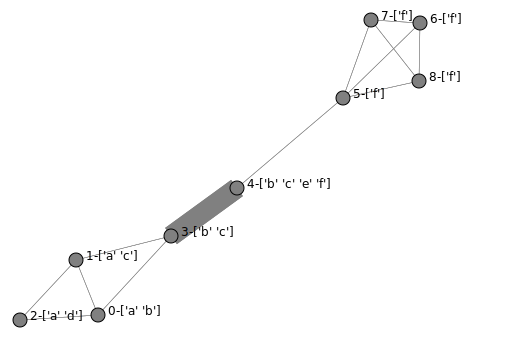

In [192]:
# Summarized graph
SVG(svg_graph(get_summarized_graph(G7, result), names=[n + '-' + str(names_col7[x.indices]) for n, x in zip(names7, X7)]))

### Custom8  

Connected common nodes one different node.

In [185]:
G8 = sparse.csr_matrix(np.array([
    [0, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0]
]))
X8 = sparse.csr_matrix(np.array([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 1, 1, 1],
]))
names8 = np.array(range(G8.shape[0])).astype(str)
names_col8 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g'])

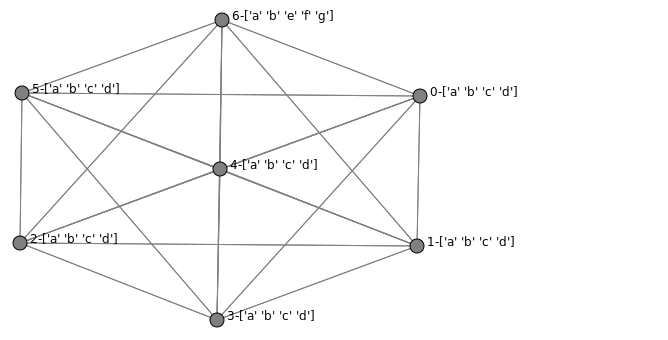

In [186]:
SVG(svg_graph(G8, names=[n + '-' + str(names_col8[x.indices]) for n, x in zip(names8, X8)]))

In [187]:
%%time
result, sorted_names_col = run_algorithm(G8, X8, names_col8, 1, 1000, 'log_custom8')

['e' 'f' 'g' 'c' 'd' 'a' 'b']
CPU times: user 12.7 ms, sys: 5.99 ms, total: 18.7 ms
Wall time: 32 ms


In [188]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5 6] ['a' 'b']
[6] ['e' 'f' 'g' 'a' 'b']
[6] ['f' 'g' 'a' 'b']
[6] ['g' 'a' 'b']
[0 1 2 3 4 5] ['c' 'd' 'a' 'b']
[0 1 2 3 4 5] ['d' 'a' 'b']


* pros:
    - concept `6` avec attributs `['e', 'f', 'g']` $\rightarrow$ le graphe ne change pas mais on continue d'ajouter des attributs qui rendent le concept un peu plus intéressant, vu le faible nombre d'occurence de ces attributs dans le graphe initial. En revanche les attributs `'a'` et `'b'` n'apportent rien d'intéressant
    - pour le concept `[0, 1, 2, 3, 4, 5]`, l'attribut `'d'` n'apporte rien à `'c'` et inversement. Encore moins les attributs `['a', 'b']` qui sont trop fréquents
* cons:
    - le concept `[0, 1, 2, 3, 4, 5]` est divisé en 2
    - le concept `6` est divisé en 3